In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import check_classification_targets
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

class OrdinalClassifier(BaseEstimator, ClassifierMixin):
    #https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c
    """
    A classifier that can be trained on a range of classes.
    @param classifier: A scikit-learn classifier.
    """
    def __init__(self,clf):
        self.clf = clf
        self.clfs = {}

    def fit(self,X,y, **kwargs):
        self.uniques_class = np.sort(np.unique(y))

        if self.uniques_class.shape[0] > 2:
            for i in range(self.uniques_class.shape[0]-1):
                #binary_y = (y > self.uniques_class[1]).astype(np.uint8)

                binary_y = (y > self.uniques_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X,binary_y, **kwargs)
                self.clfs[i] = clf

    def predict(self,X):
        return np.argmax( self.predict_proba(X), axis=1 )

    def predict_proba(self,X):
        h = [self.clfs[k].predict_proba(X)[:,1].reshape(-1,1) for k in self.clfs]

        p_x_first = 1-h[0]
        p_x_last  = h[-1]
        p_x_middle= [h[i] - h[i+1] for i in range(len(h) - 1)]
        
        probs = np.hstack([p_x_first, *p_x_middle, p_x_last])

        return probs
    
    def set_params(**params):
        # print(params)
        self.clf.set_params(**params)
    
    
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import check_classification_targets
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

class OrdinalClassifier(BaseEstimator, ClassifierMixin):
    #https://towardsdatascience.com/simple-trick-to-train-an-ordinal-regression-with-any-classifier-6911183d2a3c
    """
    A classifier that can be trained on a range of classes.
    @param classifier: A scikit-learn classifier.
    """
    def __init__(self,clf):
        self.clf = clf
        self.clfs = {}


    def fit(self,X,y):
            self.uniques_class = np.sort(np.unique(y))
            if self.uniques_class.shape[0] > 2:
                for i in range(self.uniques_class.shape[0]-1):
                    #binary_y = (y > self.uniques_class[1]).astype(np.uint8)

                    binary_y = (y > self.uniques_class[i]).astype(np.uint8)
                    clf = clone(self.clf)
                    clf.fit(X,binary_y)
                    self.clfs[i] = clf

    def predict(self,X):
        return np.argmax( self.predict_proba(X), axis=1 )

    def predict_proba(self,X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}

        predicted = []

        for i,y in enumerate(self.uniques_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:, 1])
            elif y in clfs_predict:
                #Vi = Pr(y>Vi-1)- Pr(y > Vi)
                predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                predicted.append(clfs_predict[y-1][:,1])

        return np.vstack(predicted).T

In [6]:
df = pd.read_csv('data/train.csv', index_col='Id')
X_compete = pd.read_csv('data/test.csv', index_col='Id')

X, y = df.drop(columns=['quality']), df.quality
y = y-3
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.0,0.500,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,9.3,0.300,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,7.1,0.510,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,8.1,0.870,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,8.5,0.360,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
3194,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
3195,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
3196,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
3197,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


# New Encoder

/home/mamiglia/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cohen = 0.48285419301389243 
Recall = 0.5892466395748671 
Precision = 0.5552267609453678 
Accuracy = 0.5892466395748671


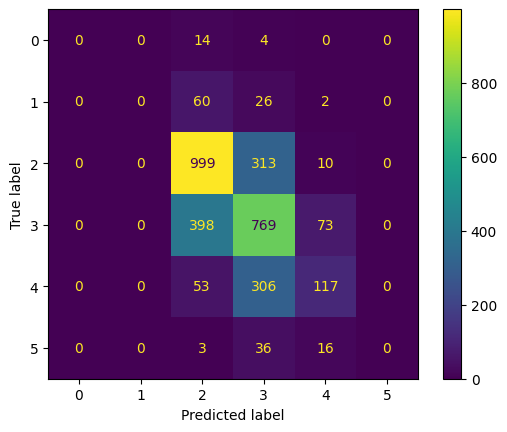

In [31]:
from sklearn.linear_model import LogisticRegression

new = OrdinalClassifier(LogisticRegression(max_iter=1e4))
new.fit(X,y)

new_pred=evaluate(X,y,new)

In [32]:
# Transfer learned classifiers
old = OrdinalClassifierOG(LogisticRegression(max_iter=1e4))
old.clf = new.clf
old.clfs = new.clfs
old.uniques_class = new.uniques_class

/home/mamiglia/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cohen = 0.48285419301389243 
Recall = 0.5892466395748671 
Precision = 0.5552267609453678 
Accuracy = 0.5892466395748671


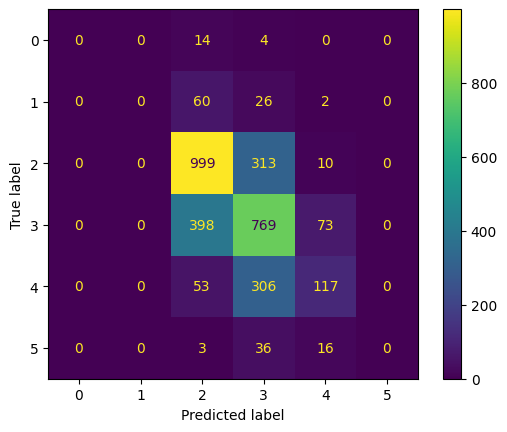

In [33]:
old_pred=evaluate(X,y,old)

In [34]:
(new_pred!=old_pred).sum()

0

# Performance

In [49]:
import timeit
M = pd.concat([X]*10, ignore_index=True)
d = {
    'type':[],
    'time':[],
    'size':[]
}

In [50]:
for i in range(1,11):
    M = pd.concat([X]*i, ignore_index=True)
    t = timeit.timeit('new.predict(M)', globals=globals(), number=100)
    d['type'].append('new')
    d['time'].append(t)
    d['size'].append(i)
    print('Epoch', i)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


In [51]:
for i in range(1,11):
    M = pd.concat([X]*i, ignore_index=True)
    t = timeit.timeit('old.predict(M)', globals=globals(), number=100)
    d['type'].append('old')
    d['time'].append(t)
    d['size'].append(i)
    print('Epoch', i)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


<AxesSubplot: xlabel='size', ylabel='time'>

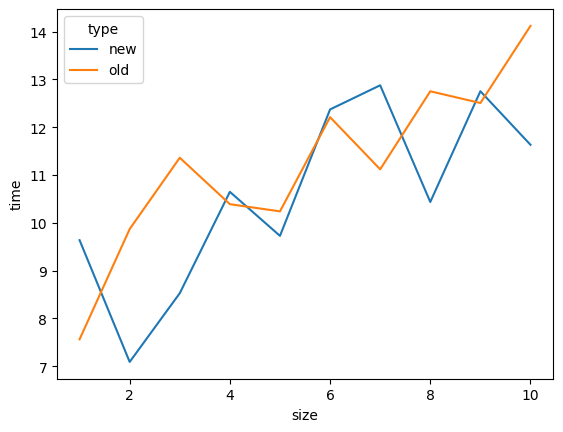

In [54]:
import seaborn as sns

df = pd.DataFrame(d)
sns.lineplot(data=df, x='size', y='time', hue='type')